2025-11-02 15:13:20.288886: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 15:13:20.293014: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 15:13:20.300211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-02 15:13:20.318899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762067600.351572   17697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762067600.36

449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


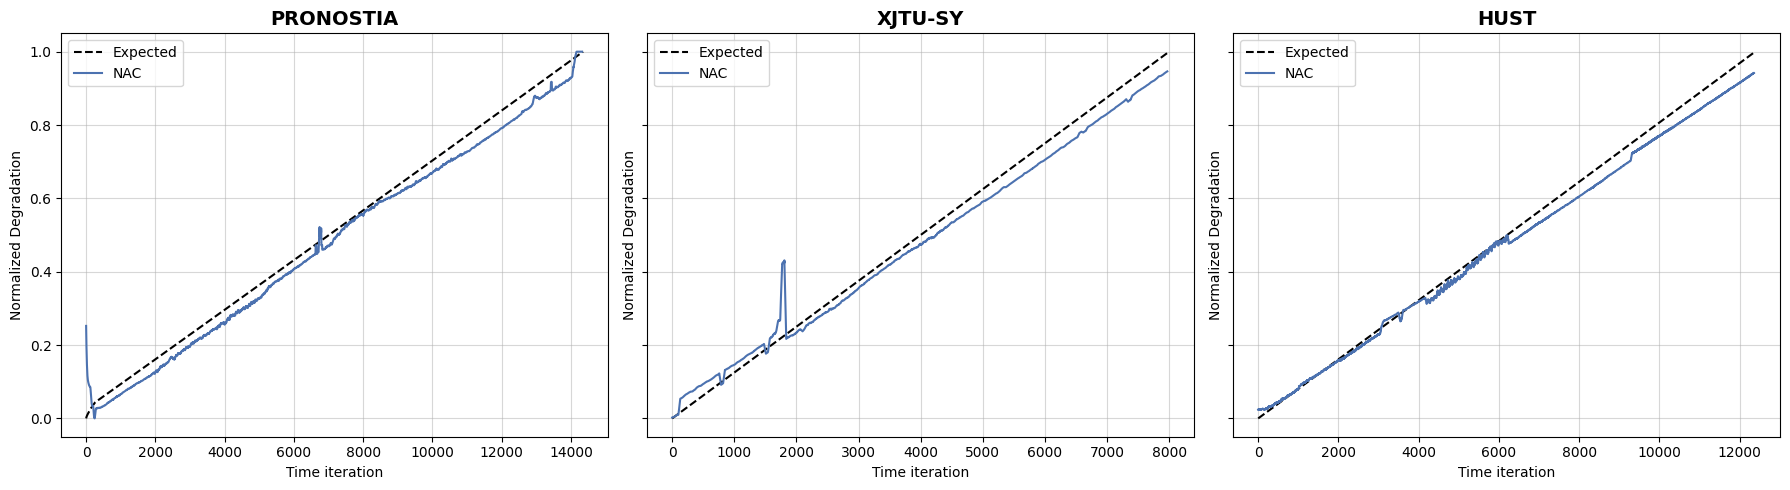

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Reshape, Conv1D
from sklearn.preprocessing import StandardScaler
from utils.preprocess import process_features
from neuronal_attention_circuit import NAC

# Directories
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

MODEL_NAME = 'RUL_NAC'
WEIGHTS_DIR = 'model_weights'

# Moving average
def moving_average(data, window_size=30):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Bearings dictionary
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}

bearing_titles = {
    "tf_features_pronostia": "PRONOSTIA",
    "tf_features_xjtu": "XJTU-SY",
    "tf_features_hust": "HUST"
}


# Build model
def build_model(input_shape=(16,)):
    inp = Input(shape=input_shape)
    x = Reshape((1,input_shape[0]))(inp)
    x = Conv1D(32,kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16,kernel_size=2, activation='relu', padding='same')(x)
    x = NAC(d_model=16,num_heads=4,delta_t=1.0,sparsity=0.5,activation='relu',return_sequences=False)(x)
    out = Dense(1, activation='linear')(x)
    return Model(inp, out)


# Model prediction
model = build_model()
model.load_weights(f"{WEIGHTS_DIR}/{MODEL_NAME}.keras")


# Prepare figure
columns = len(bearings)
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(1, columns, figsize=(6 * columns, 5), sharey=True)
if columns == 1:
    axes = [axes]

# Loop through bearings
for col_idx, (bearing_folder, bearing_file) in enumerate(bearings.items()):
    df = pd.read_csv(os.path.join(os.getcwd(), bearing_folder, bearing_file))
    
    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = np.array(df['Time'].values).reshape(-1,1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if "Degradation" in df.columns:
        y_true = df['Degradation'].values
    else:
        y_true = np.linspace(0, 1, len(df))

    y_pred = model.predict(X).squeeze()
    y_pred = np.clip(y_pred, 0, 1)

    # Plot results
    ax = axes[col_idx]
    ax.plot(y_true, label='Expected', color='black', linestyle='--')
    ax.plot(moving_average(y_pred), label=f'NAC')
    ax.set_title(bearing_titles[bearing_folder], fontweight='bold', fontsize=14)
    ax.set_xlabel('Time iteration')
    ax.set_ylabel('Normalized Degradation')
    ax.grid(alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.savefig(f'{plot_dir}/liquid_attention_single_mode.png', dpi=600)
plt.show()


449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


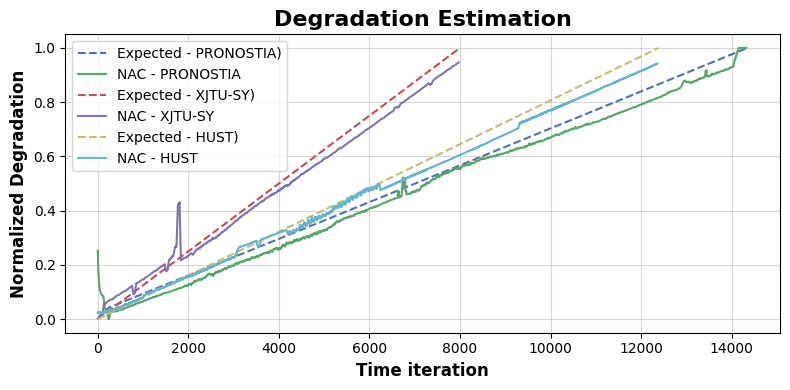

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Reshape, Conv1D
from sklearn.preprocessing import StandardScaler
from utils.preprocess import process_features
from neuronal_attention_circuit import NAC

# Directories
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

MODEL_NAME = 'RUL_NAC'
WEIGHTS_DIR = 'model_weights'

# Moving average
def moving_average(data, window_size=30):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Bearings dictionary
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}

bearing_titles = {
    "tf_features_pronostia": "PRONOSTIA",
    "tf_features_xjtu": "XJTU-SY",
    "tf_features_hust": "HUST"
}


# Build model
def build_model(input_shape=(16,)):
    inp = Input(shape=input_shape)
    x = Reshape((1,input_shape[0]))(inp)
    x = Conv1D(32,kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16,kernel_size=2, activation='relu', padding='same')(x)
    x = NAC(d_model=16,num_heads=4,delta_t=1.0,sparsity=0.5,activation='relu',return_sequences=False)(x)
    out = Dense(1, activation='linear')(x)
    return Model(inp, out)


# Model prediction
model = build_model()
model.load_weights(f"{WEIGHTS_DIR}/{MODEL_NAME}.keras")


plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(8, 4))

# Loop through bearings
for bearing_folder, bearing_file in bearings.items():
    df = pd.read_csv(os.path.join(os.getcwd(), bearing_folder, bearing_file))
    
    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = np.array(df['Time'].values).reshape(-1,1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if "Degradation" in df.columns:
        y_true = df['Degradation'].values
    else:
        y_true = np.linspace(0, 1, len(df))

    y_pred = model.predict(X).squeeze()
    y_pred = np.clip(y_pred, 0, 1)

    # Plot expected degradation
    plt.plot(y_true, label=f'Expected - {bearing_titles[bearing_folder]})', linestyle='--')
    # Plot predicted degradation
    plt.plot(moving_average(y_pred), label=f'NAC - {bearing_titles[bearing_folder]}')

plt.xlabel('Time iteration', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Degradation', fontsize=12, fontweight='bold')
plt.title('Degradation Estimation', fontweight='bold', fontsize=16)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/all_bearings_single_plot.png', dpi=600)
plt.show()


In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import tensorflow as tf
import pandas as pd
from utils.preprocess import process_features
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Conv1D, LSTMCell, GRUCell,
    RNN, SimpleRNNCell, MultiHeadAttention, Flatten, Attention
)
from tensorflow.keras.models import Model
from ncps.tf import LTCCell, CfCCell
from ncps.wirings import FullyConnected
from baseline_cells import CTRNNCell, ODELSTM, PhasedLSTM, GRUODE,ODEformer
from liquid_attention import LAN
from neuronal_attention_circuit import NAC

base_model_name = 'Degradation_Estimation'
bearings = {
    "tf_features_pronostia": "Bearing1_1_features.csv",
    "tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "tf_features_hust": "Bearing1_features.csv",
}
weights_dir = 'model_weights'

def score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    error = y_pred - y_true

    mask_early = error < 0
    mask_late = error >= 0

    score_early = tf.reduce_sum(tf.exp(-error[mask_early] / 13) - 1)
    score_late = tf.reduce_sum(tf.exp(error[mask_late] / 10) - 1)

    return score_early + score_late

# Wiring for custom cells
wiring = FullyConnected(32)

def build_model(cell_type, input_shape=(16,), num_classes=1):
    inp = Input(shape=input_shape)
    x = Reshape((1, input_shape[0]))(inp)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16, kernel_size=2, activation='relu', padding='same')(x)

    if cell_type == "RNNCell":
        x = RNN(SimpleRNNCell(16), return_sequences=False)(x)
    elif cell_type == "LSTMCell":
        x = RNN(LSTMCell(16), return_sequences=False)(x)
    elif cell_type == "GRUCell":
        x = RNN(GRUCell(16), return_sequences=False)(x)
    elif cell_type == "LTCCell":
        x = RNN(LTCCell(wiring), return_sequences=False)(x)
    elif cell_type == "CfCCell":
        x = RNN(CfCCell(16), return_sequences=False)(x)
    elif cell_type == "ODELSTM":
        x = RNN(ODELSTM(16), return_sequences=False)(x)
    elif cell_type == "PhasedLSTM":
        x = RNN(PhasedLSTM(16), return_sequences=False)(x)
    elif cell_type == "GRUODE":
        x = RNN(GRUODE(16), return_sequences=False)(x)
    elif cell_type == "CTRNNCell":
        x = RNN(CTRNNCell(16, num_unfolds=5, method='euler'), return_sequences=False)(x)
    elif cell_type == "Attention":
        x = Attention()([x, x])
        x = Flatten()(x)
    elif cell_type == "MultiHeadAttention":
        x = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
        x = Flatten()(x)
    elif cell_type == "LAN_Exact":
        x = LAN(d_model=16, num_heads=8, mode="exact", return_sequences=False)(x)
    elif cell_type == "LAN_Euler":
        x = LAN(d_model=16, num_heads=8, mode="euler", euler_steps=20, return_sequences=False)(x)
    elif cell_type == "LAN_Steady":
        x = LAN(d_model=16, num_heads=8, mode="steady", return_sequences=False)(x)
    elif cell_type == "odeformer":
        x = ODEformer(hidden_dim=16, num_heads=8, ff_dim=64)(x)
        x = Flatten()(x)
    elif cell_type == "NAC":
        x = NAC(d_model=16,num_heads=4,delta_t=1.0,sparsity=0.5,activation='relu',return_sequences=False)(x)
    else:
        raise ValueError(f"Unknown cell type: {cell_type}")

    out = Dense(num_classes, activation='linear')(x)
    return Model(inp, out)

# List of model types
model_types = [
    "RNNCell", "LSTMCell", "GRUCell", 'GRUODE', 'CTRNNCell', 'PhasedLSTM',
    'ODELSTM', "CfCCell", "LTCCell", 
    "MultiHeadAttention", 'Attention', "odeformer",
    "LAN_Exact", "LAN_Euler", "LAN_Steady",
    "NAC"
]

k_folds = 5
results = {}

for feature_dir, filename in bearings.items():
    print(f"\n=== Evaluating dataset: {feature_dir} ===")

    df = pd.read_csv(f"{feature_dir}/{filename}")

    # Process features
    X_h = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    X_v = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((X_h, X_v), axis=-1)

    t_data = df['Time'].values.reshape(-1, 1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)

    if "Degradation" in df.columns:
        y = df['Degradation'].values.reshape(-1, 1)
    else:
        y = np.linspace(0, 1, len(df)).reshape(-1, 1)

    # Combine and normalize
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dataset = tf.data.Dataset.from_tensor_slices((X_scaled, y)).batch(64)

    for cell_type in model_types:
        model_name = f"{base_model_name}_{cell_type}"
        print(f"\nTesting {model_name} on {feature_dir}...")

        fold_score = []

        for fold in range(1, k_folds + 1):
            model = build_model(cell_type, input_shape=(16,))
            weight_file = f"{weights_dir}/{model_name}_fold{fold}.weights.h5"

            if not os.path.exists(weight_file):
                print(f"  Skipping fold {fold}: no weights found at {weight_file}")
                continue

            model.load_weights(weight_file)
            y_true, y_pred = [], []

            for X_batch, y_batch in dataset:
                preds = model.predict(X_batch, verbose=0)
                y_true.append(y_batch.numpy())
                y_pred.append(preds)

            y_true = np.vstack(y_true).squeeze()
            y_pred = np.vstack(y_pred).squeeze()

            fold_s = score(y_true, y_pred).numpy().squeeze()
            fold_score.append(fold_s)

        if fold_score:
            mean_acc = np.mean(fold_score)
            std_acc = np.std(fold_score)
            results[(feature_dir, cell_type)] = {"fold_score": fold_score, "mean": mean_acc, "std": std_acc}

            print(f"Scores: {fold_score}")
            print(f"Mean={mean_acc:.4f}, Std={std_acc:.4f}")

# Final summary
print("\n=== Final Results ===")
for (feature_dir, cell_type), data in results.items():
    print(f"{feature_dir} - {base_model_name}_{cell_type}: Mean={data['mean']:.4f}, Std={data['std']:.4f}")


2025-11-03 19:27:15.231528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-03 19:27:15.234707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-03 19:27:15.245838: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-03 19:27:15.268343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762169235.322177   31333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762169235.33


=== Evaluating dataset: tf_features_pronostia ===


W0000 00:00:1762169245.498750   31333 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Testing Degradation_Estimation_RNNCell on tf_features_pronostia...


2025-11-03 19:28:32.075530: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-03 19:29:33.463553: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-03 19:31:44.028342: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [41.370018, 30.116919, 48.23831, 51.54866, 38.99537]
Mean=42.0539, Std=7.4928

Testing Degradation_Estimation_LSTMCell on tf_features_pronostia...


2025-11-03 19:36:12.450769: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [40.88909, 37.326435, 43.65111, 45.957176, 41.536976]
Mean=41.8722, Std=2.8842

Testing Degradation_Estimation_GRUCell on tf_features_pronostia...
Scores: [52.45809, 40.32641, 42.892532, 39.822784, 45.58968]
Mean=44.2179, Std=4.6043

Testing Degradation_Estimation_GRUODE on tf_features_pronostia...


/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(
2025-11-03 19:45:16.154828: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [41.01588, 34.553364, 37.28128, 38.769325, 43.921535]
Mean=39.1083, Std=3.1939

Testing Degradation_Estimation_CTRNNCell on tf_features_pronostia...
Scores: [55.291656, 37.032272, 32.464703, 52.28257, 44.528183]
Mean=44.3199, Std=8.6889

Testing Degradation_Estimation_PhasedLSTM on tf_features_pronostia...
Scores: [49.126297, 36.160385, 43.620174, 49.10309, 42.732964]
Mean=44.1486, Std=4.8046

Testing Degradation_Estimation_ODELSTM on tf_features_pronostia...


2025-11-03 20:04:29.651288: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [47.4198, 49.29767, 45.000973, 56.882103, 43.888687]
Mean=48.4978, Std=4.5950

Testing Degradation_Estimation_CfCCell on tf_features_pronostia...
Scores: [43.950363, 45.842842, 50.232445, 53.495453, 45.38729]
Mean=47.7817, Std=3.5447

Testing Degradation_Estimation_LTCCell on tf_features_pronostia...
Scores: [48.496536, 47.24832, 51.033485, 54.499924, 39.426]
Mean=48.1409, Std=5.0135

Testing Degradation_Estimation_MultiHeadAttention on tf_features_pronostia...
Scores: [49.852417, 36.568806, 46.544167, 50.740097, 43.09773]
Mean=45.3606, Std=5.1562

Testing Degradation_Estimation_Attention on tf_features_pronostia...
Scores: [34.909424, 43.873997, 45.977356, 51.654907, 33.02175]
Mean=41.8875, Std=6.9767

Testing Degradation_Estimation_odeformer on tf_features_pronostia...
Scores: [31.779495, 39.862823, 52.924667, 45.978016, 41.569233]
Mean=42.4228, Std=6.9784

Testing Degradation_Estimation_LAN_Exact on tf_features_pronostia...


2025-11-03 20:24:28.815580: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [44.304348, 41.895107, 44.534622, 48.71694, 46.430977]
Mean=45.1764, Std=2.2825

Testing Degradation_Estimation_LAN_Euler on tf_features_pronostia...
Scores: [43.86426, 38.7195, 48.173824, 46.92257, 41.510185]
Mean=43.8381, Std=3.4621

Testing Degradation_Estimation_LAN_Steady on tf_features_pronostia...
Scores: [42.040512, 49.740818, 42.62613, 43.26317, 44.6131]
Mean=44.4567, Std=2.7770

Testing Degradation_Estimation_NAC on tf_features_pronostia...
Scores: [35.576153, 46.297615, 33.25603, 42.155415, 38.668716]
Mean=39.1908, Std=4.6445

=== Evaluating dataset: tf_features_xjtu ===

Testing Degradation_Estimation_RNNCell on tf_features_xjtu...
Scores: [35.56948, 31.37294, 18.395947, 36.993603, 33.01633]
Mean=31.0697, Std=6.6309

Testing Degradation_Estimation_LSTMCell on tf_features_xjtu...
Scores: [38.56082, 27.386858, 38.53483, 37.788826, 17.666466]
Mean=31.9876, Std=8.3185

Testing Degradation_Estimation_GRUCell on tf_features_xjtu...
Scores: [26.647745, 27.517452, 26.867392

/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Scores: [44.58257, 21.42482, 24.771778, 27.232819, 37.96734]
Mean=31.1959, Std=8.6891

Testing Degradation_Estimation_CTRNNCell on tf_features_xjtu...
Scores: [41.393288, 27.981506, 21.998455, 15.070999, 23.60125]
Mean=26.0091, Std=8.7417

Testing Degradation_Estimation_PhasedLSTM on tf_features_xjtu...
Scores: [46.024826, 32.122192, 32.64962, 35.958553, 30.701073]
Mean=35.4913, Std=5.5416

Testing Degradation_Estimation_ODELSTM on tf_features_xjtu...
Scores: [19.779713, 31.624708, 26.287628, 28.728907, 29.275402]
Mean=27.1393, Std=4.0521

Testing Degradation_Estimation_CfCCell on tf_features_xjtu...
Scores: [29.826248, 39.15493, 40.605553, 34.836212, 33.10943]
Mean=35.5065, Std=3.9439

Testing Degradation_Estimation_LTCCell on tf_features_xjtu...
Scores: [35.164864, 29.176407, 51.466602, 27.928068, 40.410072]
Mean=36.8292, Std=8.5749

Testing Degradation_Estimation_MultiHeadAttention on tf_features_xjtu...


2025-11-03 20:41:17.198614: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Scores: [38.147957, 33.914925, 21.67721, 59.0916, 33.717384]
Mean=37.3098, Std=12.1980

Testing Degradation_Estimation_Attention on tf_features_xjtu...


2025-11-03 20:42:09.860365: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


Scores: [21.826374, 24.985004, 28.80771, 32.87562, 22.955055]
Mean=26.2900, Std=4.0610

Testing Degradation_Estimation_odeformer on tf_features_xjtu...
Scores: [38.189014, 43.532127, 43.283314, 18.35669, 34.774586]
Mean=35.6271, Std=9.2376

Testing Degradation_Estimation_LAN_Exact on tf_features_xjtu...
Scores: [38.879856, 38.773643, 44.863873, 43.53908, 29.796196]
Mean=39.1705, Std=5.2843

Testing Degradation_Estimation_LAN_Euler on tf_features_xjtu...
Scores: [24.332006, 24.408695, 40.124474, 33.365463, 28.304802]
Mean=30.1071, Std=6.0006

Testing Degradation_Estimation_LAN_Steady on tf_features_xjtu...
Scores: [29.477108, 20.12415, 37.29772, 34.272724, 45.52964]
Mean=33.3403, Std=8.4226

Testing Degradation_Estimation_NAC on tf_features_xjtu...
Scores: [20.774307, 30.272356, 25.56506, 19.214191, 44.16841]
Mean=27.9989, Std=8.9656

=== Evaluating dataset: tf_features_hust ===

Testing Degradation_Estimation_RNNCell on tf_features_hust...
Scores: [57.179977, 40.887833, 42.465023, 37.6

/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


Scores: [50.76712, 35.93814, 41.121613, 53.80051, 37.935104]
Mean=43.9125, Std=7.0974

Testing Degradation_Estimation_CTRNNCell on tf_features_hust...
Scores: [37.87619, 47.151936, 37.949158, 30.237865, 46.730034]
Mean=39.9890, Std=6.3318

Testing Degradation_Estimation_PhasedLSTM on tf_features_hust...
Scores: [49.34955, 35.312542, 34.210945, 38.749325, 35.664753]
Mean=38.6574, Std=5.5542

Testing Degradation_Estimation_ODELSTM on tf_features_hust...
Scores: [30.63267, 51.102833, 30.004496, 37.069195, 51.74385]
Mean=40.1106, Std=9.5643

Testing Degradation_Estimation_CfCCell on tf_features_hust...
Scores: [49.53855, 51.703663, 69.237976, 60.564606, 39.40087]
Mean=54.0891, Std=10.1347

Testing Degradation_Estimation_LTCCell on tf_features_hust...
Scores: [56.61169, 53.441025, 91.10823, 45.452175, 62.46895]
Mean=61.8164, Std=15.6426

Testing Degradation_Estimation_MultiHeadAttention on tf_features_hust...
Scores: [45.803226, 35.521957, 34.18879, 54.52305, 36.938965]
Mean=41.3952, Std=7.